<a href="https://colab.research.google.com/github/Merna177/airbnbPrediction/blob/master/AirbnbPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#reading data from drive
!ls "/content/drive/My Drive/DatasetAirbnb/"
data = "/content/drive/My Drive/DatasetAirbnb/"

sessions.csv  test_users.csv  train_users_2.csv


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
import pandas as pd
import csv
from tqdm import trange
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Reading Data
trainUsers = pd.read_csv(data+ "train_users_2.csv")
testUsers = pd.read_csv(data +"test_users.csv")
print(trainUsers.shape[0], "users in the training Dataset &", testUsers.shape[0], "users in the test Dataset.") 


213451 users in the training Dataset & 62096 users in the test Dataset.


In [5]:
trainUsers.head()


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [0]:
session = pd.read_csv(data +"sessions.csv")


In [7]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


#**Pre** **processing**

In [0]:
total = pd.concat((trainUsers, testUsers), axis = 0, ignore_index = True, sort = True)

Check if there any missing data

In [9]:
trainUsers.isnull().values.any()


True

Check the Null values


In [11]:
#Check Null Values in Total Dataset
print(total.isnull().sum())

affiliate_channel               0
affiliate_provider              0
age                        116866
country_destination         62096
date_account_created            0
date_first_booking         186639
first_affiliate_tracked      6085
first_browser                   0
first_device_type               0
gender                          0
id                              0
language                        0
signup_app                      0
signup_flow                     0
signup_method                   0
timestamp_first_active          0
dtype: int64


In [10]:
print(trainUsers.isnull().sum())

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64


In [12]:
print(testUsers.isnull().sum())

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64


In [0]:
trainUsers.drop("date_first_booking", axis = 1, inplace=True)
testUsers.drop("date_first_booking", axis = 1, inplace=True)
total.drop("date_first_booking", axis = 1, inplace=True)


In [14]:
# i tried this for each feature to detect which features have Unkown Values
total.signup_method.unique()

array(['facebook', 'basic', 'google', 'weibo'], dtype=object)

In [0]:
# replace unkown values with NAN
total.gender.replace("-unknown-", np.nan, inplace=True)
total.first_browser.replace("-unknown-", np.nan, inplace=True)
trainUsers.gender.replace("-unknown-", np.nan, inplace=True)
trainUsers.first_browser.replace("-unknown-", np.nan, inplace=True)
testUsers.gender.replace("-unknown-", np.nan, inplace=True)
testUsers.first_browser.replace("-unknown-", np.nan, inplace=True)
total.language.replace("-unknown-", np.nan, inplace=True)
trainUsers.language.replace("-unknown-", np.nan, inplace=True)
testUsers.language.replace("-unknown-", np.nan, inplace=True)
total.first_affiliate_tracked.replace("untracked", np.nan, inplace=True)
trainUsers.first_affiliate_tracked.replace("untracked", np.nan, inplace=True)
testUsers.first_affiliate_tracked.replace("untracked", np.nan, inplace=True)


In [0]:
total.age.describe()
#Some users introduced a year instead of their age, translate this year into their age
wrong = total['age'] > 1000
total.loc[wrong, 'age'] = 2015 - total.loc[wrong, 'age']
wrongtr = trainUsers['age'] > 1000
trainUsers.loc[wrongtr, 'age'] = 2015 - trainUsers.loc[wrongtr, 'age']
wrongtest = testUsers['age'] > 1000
testUsers.loc[wrongtest, 'age'] = 2015 - testUsers.loc[wrongtest, 'age']

add some limit to the age

In [0]:
total.loc[total.age > 100, 'age'] = np.nan
total.loc[total.age < 18, 'age'] = np.nan
trainUsers.loc[trainUsers.age > 100, 'age'] = np.nan
trainUsers.loc[trainUsers.age < 18, 'age'] = np.nan
testUsers.loc[testUsers.age > 100, 'age'] = np.nan
testUsers.loc[testUsers.age < 18, 'age'] = np.nan

represent age distribution

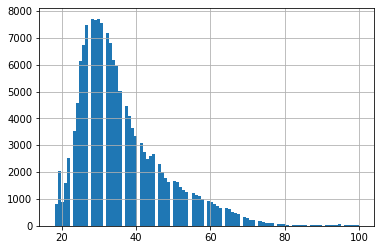

In [18]:
hist = total['age'].hist(bins=100)


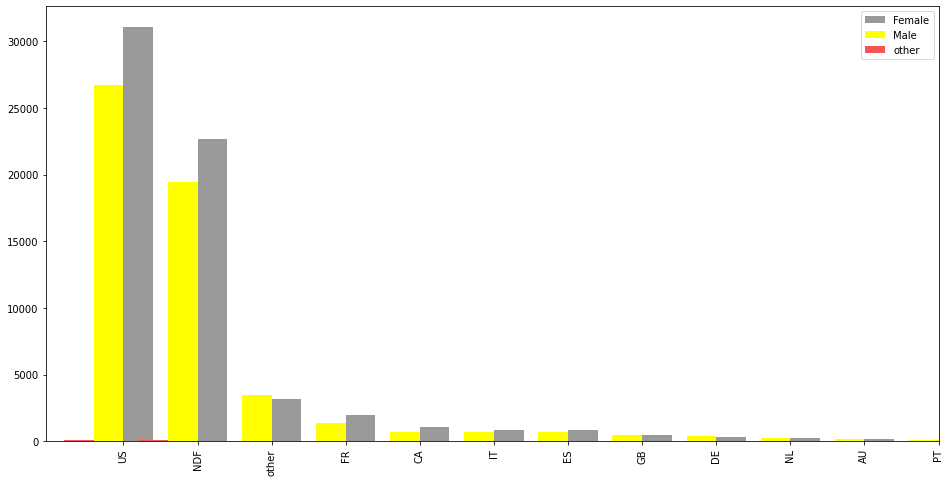

In [19]:

total.loc[total['gender'] == 'FEMALE', 'country_destination'].value_counts().plot(kind='bar', label='Female', position=0, figsize=(16,8), width = 0.4, color='#999999')
total.loc[total['gender'] == 'MALE', 'country_destination'].value_counts().plot(kind='bar', label='Male', position=1, figsize=(16,8), width = 0.4, color='#FFFF00')
total.loc[total['gender'] == 'OTHER', 'country_destination'].value_counts().plot(kind='bar', label='other', position=2, figsize=(16,8), width = 0.4, color='#F45656')

plt.legend()
plt.show()

In [20]:
##to know the count of each country as Destination
trainUsers['country_destination'].value_counts()


NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

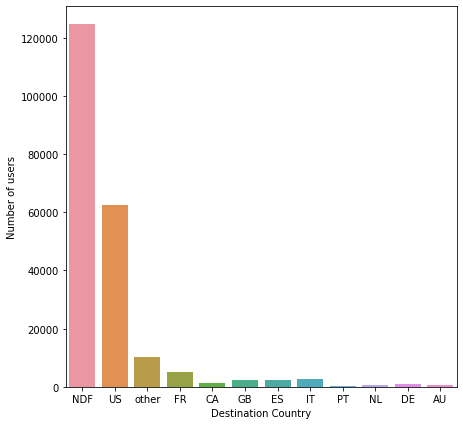

In [21]:
#plot for country Destination
plt.figure(figsize=(7,7))
sns.countplot(x='country_destination', data=trainUsers)
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.show()

Note: around 120K from 213451 endup without pick a destination 

In [22]:
trainUsers['country_destination'].value_counts()['NDF']/trainUsers['country_destination'].shape[0]
#this mean that more than half of the users endup without a destination

0.5834734904029496

In [23]:
trainUsers['gender'].value_counts()


FEMALE    63041
MALE      54440
OTHER       282
Name: gender, dtype: int64

So let check who endup with a destination.

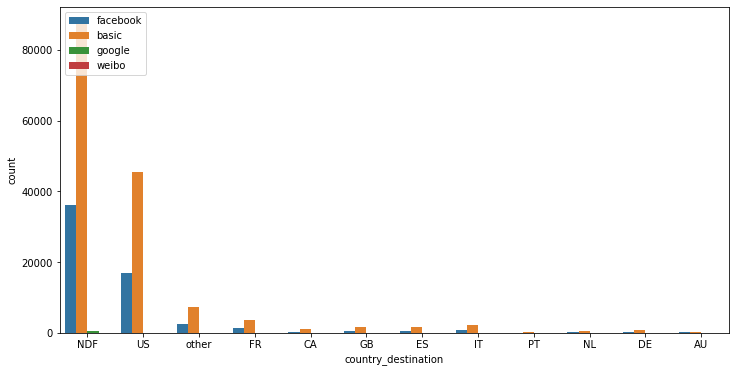

In [24]:
# Destination vs signupMethods
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data = total, hue = 'signup_method')
plt.legend()
plt.show()

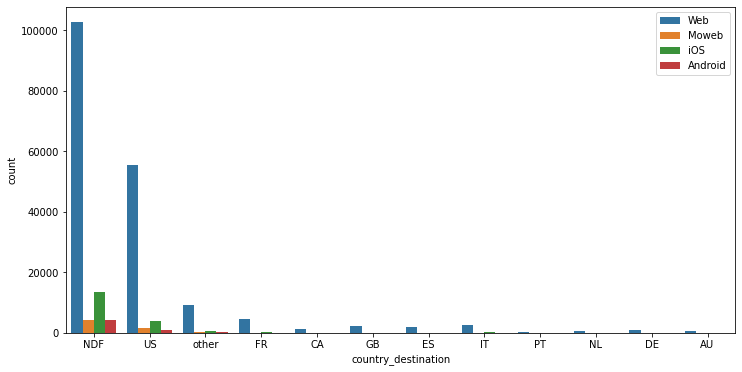

In [25]:
#Destination vs signup app
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data=total,hue = 'signup_app')
plt.legend()
plt.show()

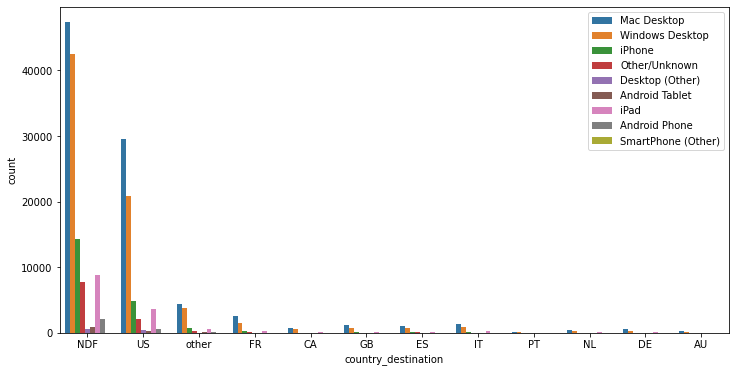

In [26]:
#Destination vs first device type
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data=total,hue = 'first_device_type')
plt.legend()
plt.show()

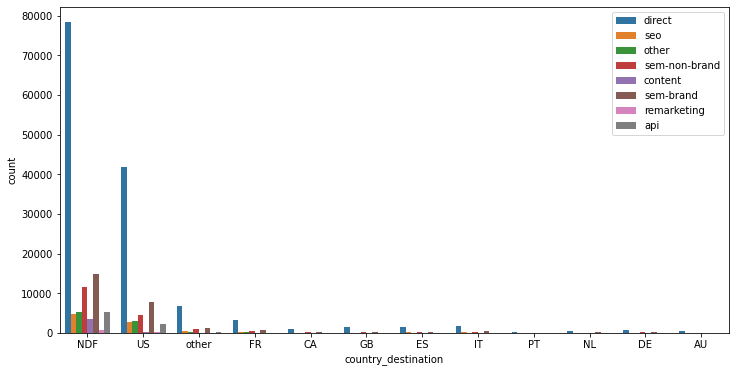

In [27]:

#Destination vs affiliate_channel
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data=total,hue = 'affiliate_channel')
plt.legend()
plt.show()
#most of people visit airbnb direct

In [0]:
total['date_account_created'] = pd.to_datetime(total['date_account_created'])
total['timestamp_first_active'] = pd.to_datetime((total.timestamp_first_active // 1000000), format='%Y%m%d')

In [0]:
trainUsers['date_account_created'] = pd.to_datetime(trainUsers['date_account_created'])
trainUsers['timestamp_first_active'] = pd.to_datetime((trainUsers.timestamp_first_active // 1000000), format='%Y%m%d')
testUsers['date_account_created'] = pd.to_datetime(testUsers['date_account_created'])
testUsers['timestamp_first_active'] = pd.to_datetime((testUsers.timestamp_first_active // 1000000), format='%Y%m%d')

In [0]:
total['weekday_account_created'] = total['date_account_created'].dt.day_name()

In [0]:
total['day_account_created'] = total.date_account_created.dt.day
total['month_account_created'] = total.date_account_created.dt.month
total['year_account_created'] = total.date_account_created.dt.year

In [0]:

total['weekday_first_active'] = total.timestamp_first_active.dt.day_name()
total['day_first_active'] = total.timestamp_first_active.dt.day
total['month_first_active'] = total.timestamp_first_active.dt.month
total['year_first_active'] = total.timestamp_first_active.dt.year

Calculate time lag

In [0]:
total['time_lag'] = (total['date_account_created'] - total['timestamp_first_active'])
total.drop( ['date_account_created', 'timestamp_first_active'], axis=1, inplace=True)

Fill NAN 

In [0]:
total['age'].fillna(-1, inplace=True)
total['gender'].fillna('none', inplace=True)
total['language'].fillna('none', inplace=True)
total['first_browser'].fillna('none', inplace=True)
total['first_affiliate_tracked'].fillna('none', inplace=True)


#Session Data

In [35]:
print(session.isnull().sum())

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64


In [0]:
sessionTrain = pd.merge(total, session, how = 'left', left_on = 'id', right_on = 'user_id')

In [0]:
for col in ['action','action_type','action_detail']:
        session[col] = session[col].fillna('none')
session.loc[:, 'secs_elapsed'].fillna(0, inplace=True)

In [0]:
#ename the column user_id as just id to match the train
session.rename(columns = {'user_id': 'id'}, inplace=True)

In [0]:
#replace rare action with other value
mn = 100
action_counts = session['action'].value_counts()
rare_actions = action_counts[action_counts < mn].index.tolist()
session.loc[session['action'].isin(rare_actions), 'action'] = 'other'    
action_detail_counts = session['action_detail'].value_counts()
rare_action_details = action_detail_counts[action_detail_counts < mn].index.tolist()
session.loc[session['action_detail'].isin(rare_action_details), 'action_detail'] = 'other'

In [0]:
mostUsedDevice= session.groupby('id')['device_type'].max()
mostUsedDevice = mostUsedDevice.to_frame()
mostUsedDevice = mostUsedDevice.rename(columns={'device_type': 'most_used_device'})

In [0]:
time= session.groupby('id')['secs_elapsed'].sum()
time = time.to_frame()
time = time.rename(columns={'secs_elapsed': 'sumTime'})

In [0]:
sessionData = pd.merge(time, mostUsedDevice, how = 'inner', left_on = 'id', right_on = 'id')


sumTime        135483
device_type    135483
dtype: int64

In [43]:
DataSet = pd.merge(total, sessionData, how = 'left', left_on = 'id', right_on = 'id')
DataSet.tail(20)

,affiliate_channel,affiliate_provider,age,country_destination,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,weekday_account_created,day_account_created,month_account_created,year_account_created,weekday_first_active,day_first_active,month_first_active,year_first_active,time_lag,sumTime,most_used_device
275527,seo,facebook,39.0,NaN,none,Mobile Safari,iPhone,MALE,1xa5t3t0la,en,Web,0,facebook,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,277706.0,iPhone
275528,seo,google,-1.0,NaN,none,Firefox,Mac Desktop,none,zuvz7gfpjz,en,Web,0,basic,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,938847.0,Mac Desktop
275529,seo,google,-1.0,NaN,none,Mobile Safari,iPad,none,gpusl6ppgf,en,Web,0,basic,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,715253.0,iPad Tablet
275530,seo,google,44.0,NaN,linked,Chrome,Mac Desktop,MALE,gpijioh4eh,en,Web,0,basic,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,6288548.0,Mac Desktop
275531,seo,google,39.0,NaN,linked,Firefox,Windows Desktop,none,3ptlvdxss9,en,Web,0,basic,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,1052227.0,Windows Desktop
275532,direct,direct,34.0,NaN,none,none,Android Phone,FEMALE,f9a1ncjnrg,en,Android,23,facebook,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,980574.0,Android Phone
275533,seo,google,-1.0,NaN,none,Safari,Mac Desktop,none,kofaz2kh70,en,Web,0,basic,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,526862.0,Mac Desktop
275534,direct,direct,40.0,NaN,none,none,Android Phone,MALE,6xrmom7hjo,en,Android,23,facebook,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,86052.0,Android Phone
275535,direct,direct,27.0,NaN,none,Firefox,Mac Desktop,MALE,cg9wqgnad2,en,Web,0,facebook,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,882738.0,Mac Desktop
275536,direct,direct,24.0,NaN,linked,Mobile Safari,iPhone,FEMALE,jg618z94wo,en,Web,0,facebook,Tuesday,30,9,2014,Tuesday,30,9,2014,0 days,575391.0,iPhone


In [45]:
categorical_features = ['gender', 'signup_method', 'signup_flow', 'language','affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'most_used_device', 'weekday_account_created', 'weekday_first_active','time_lag'
,'year_first_active','month_first_active','day_first_active','year_account_created','month_account_created','day_account_created']
df = pd.get_dummies(DataSet, columns=categorical_features)
df.tail()

,age,country_destination,id,sumTime,gender_FEMALE,gender_MALE,gender_OTHER,gender_none,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_14,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,...,month_account_created_4,month_account_created_5,month_account_created_6,month_account_created_7,month_account_created_8,month_account_created_9,month_account_created_10,month_account_created_11,month_account_created_12,day_account_created_1,day_account_created_2,day_account_created_3,day_account_created_4,day_account_created_5,day_account_created_6,day_account_created_7,day_account_created_8,day_account_created_9,day_account_created_10,day_account_created_11,day_account_created_12,day_account_created_13,day_account_created_14,day_account_created_15,day_account_created_16,day_account_created_17,day_account_created_18,day_account_created_19,day_account_created_20,day_account_created_21,day_account_created_22,day_account_created_23,day_account_created_24,day_account_created_25,day_account_created_26,day_account_created_27,day_account_created_28,day_account_created_29,day_account_created_30,day_account_created_31
275542,31.0,NaN,cv0na2lf5a,2534232.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
275543,-1.0,NaN,zp8xfonng8,51618.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
275544,-1.0,NaN,fa6260ziny,823297.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
275545,-1.0,NaN,87k0fy4ugm,352068.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
275546,49.0,NaN,9uqfg8txu3,2804544.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Split train and test

In [0]:

df.set_index('id', inplace=True)
train_df = df.loc[trainUsers['id']]
train_df.reset_index(inplace=True)
train_df.fillna(-1, inplace=True)

In [47]:
#Creating target variable for the train dataset
y_train = train_df['country_destination']
train_df.drop(['country_destination', 'id'], axis=1, inplace=True)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train) #Transforming the target variable using labels
#We see that the destination countries have been successfully encoded now
encoded_y_train

array([ 7,  7, 10, ...,  7,  7,  7])

In [0]:
#Create test
#Creating test set
test_df = df.loc[testUsers['id']].drop('country_destination', axis=1)
test_df.reset_index(inplace=True)
id_test = test_df['id']
test_df.drop('id', axis=1, inplace=True)

In [49]:
#remove Duplicates if exist
test_df.columns[test_df.columns.duplicated()]


Index([], dtype='object')

Model and prediction

In [50]:
import xgboost as xgb
xboostTrain = xgb.DMatrix(train_df, label=encoded_y_train)
#Specifying the hyperparameters
params = {'max_depth': 20,
    'learning_rate': 0.9,
    'n_estimators': 4,
    'objective': 'multi:softprob',
    'num_class': 12,
    'gamma': 0,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'base_score': 0.5,
    'missing': None,
    'nthread': 4,
    'seed': 42
          }
num_boost_round = 5
print("Train a XGBoost model")
gbm = xgb.train(params, xboostTrain, num_boost_round)

Train a XGBoost model


In [0]:
y_pred = gbm.predict(xgb.DMatrix(test_df))
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 3
    cts += label_encoder.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()
predict = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

In [0]:
predict.to_csv('prediction.csv',index=False)
